# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import time
import numpy as np

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

from consav import elapsed

from FullHANKSAMModel import FullHANKSAMModelClass
from figures import create_fig, save_fig, vary_par, IRF_figs

# Setup

In [2]:
model = FullHANKSAMModelClass(name='baseline')
model.load_parameters('calibration')
model.load_data()

In [3]:
model_HtM_debt = model.copy()
model_HtM_debt.load_parameters('calibration_HtM_debt')
model_HtM_debt.load_data()

In [4]:
models = [model,model_HtM_debt]

# Solve

In [5]:
for model_ in models:
    model_.find_ss()
    model_.compute_jacs(skip_shocks=True)
    model_.find_transition_path()

# Supply vs. demand

In [6]:
model_demand = model.copy()

In [7]:
model_demand.par.jump_shock_TFP = 0.0
model_demand.par.jump_shock_beta = (1.0+0.0108)**(1/12)-1.0

In [8]:
model_demand.find_transition_path()

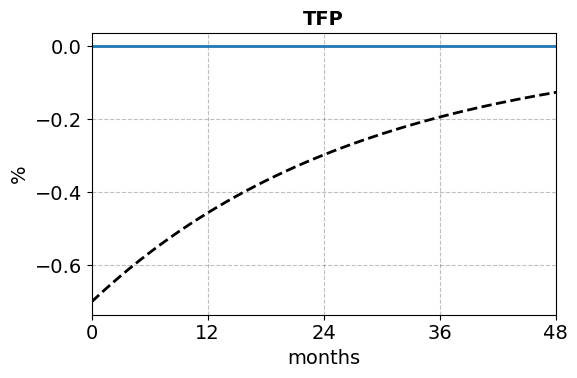

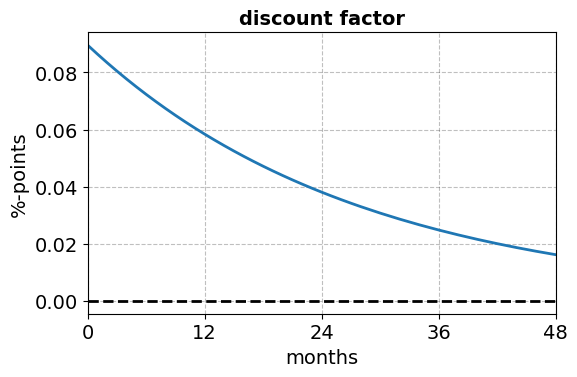

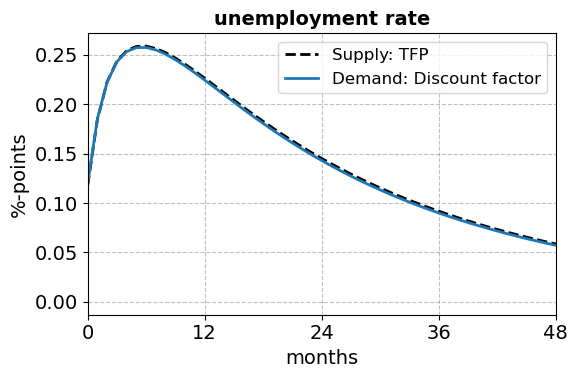

In [9]:
for varname,title in [('shock_TFP','TFP'),('shock_beta','discount factor'),('u','unemployment rate')]:
    
    fig,ax = create_fig()
    
    # a. model   
    y,ylabel = model.get_IRF(varname)
    ax.plot(y,label=f'Supply: TFP',color='black',lw=2,ls='--')

    y,_ = model_demand.get_IRF(varname)
    ax.plot(y,label=f'Demand: Discount factor',lw=2)
    
    save_fig(fig,ax,
             filename=f'supply_vs_demand_shock_{varname}.pdf',
             title=title,
             ylabel=ylabel,legend=varname=='u')    

# Varying parameters

In [10]:
values_dict = {}
values_dict['phi'] = [50.0,200.0,400.0,600.0]
values_dict['delta_pi'] = [1.1,1.5,2.0,3.0]

latex_dict = {}
latex_dict['phi'] = '\\phi'
latex_dict['delta_pi'] = '\\delta_pi'

phi
baseline
baseline: phi = 600.0000
phi = 50.0000: var_u =  1.05, C_drop_ss = -19.2, , C_drop_ini_ss =  -7.5
phi = 200.0000: var_u =  1.18, C_drop_ss = -19.2, , C_drop_ini_ss =  -7.5
phi = 400.0000: var_u =  1.32, C_drop_ss = -19.2, , C_drop_ini_ss =  -7.5
phi = 600.0000: var_u =  1.37, C_drop_ss = -19.2, , C_drop_ini_ss =  -7.5
completed in 58.1 secs

HtM_debt
baseline: phi = 600.0000
phi = 50.0000: var_u =  1.03, C_drop_ss = -21.2, , C_drop_ini_ss = -10.6
phi = 200.0000: var_u =  1.06, C_drop_ss = -21.2, , C_drop_ini_ss = -10.6
phi = 400.0000: var_u =  1.00, C_drop_ss = -21.2, , C_drop_ini_ss = -10.6
phi = 600.0000: var_u =  0.90, C_drop_ss = -21.2, , C_drop_ini_ss = -10.6
completed in 57.1 secs


delta_pi
baseline
baseline: delta_pi = 1.5000
delta_pi =  1.1000: var_u =  1.03, C_drop_ss = -19.2, , C_drop_ini_ss =  -7.5
delta_pi =  1.5000: var_u =  1.37, C_drop_ss = -19.2, , C_drop_ini_ss =  -7.5
delta_pi =  2.0000: var_u =  1.32, C_drop_ss = -19.2, , C_drop_ini_ss =  -7.5
delta_pi 

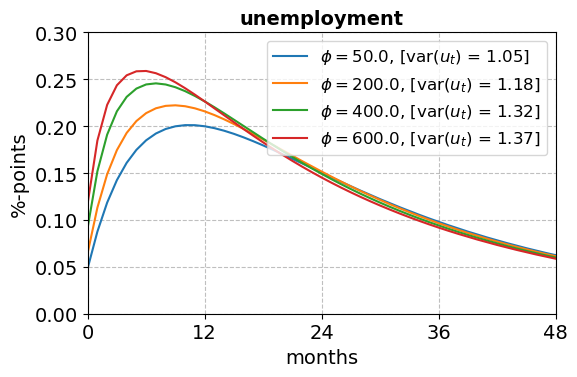

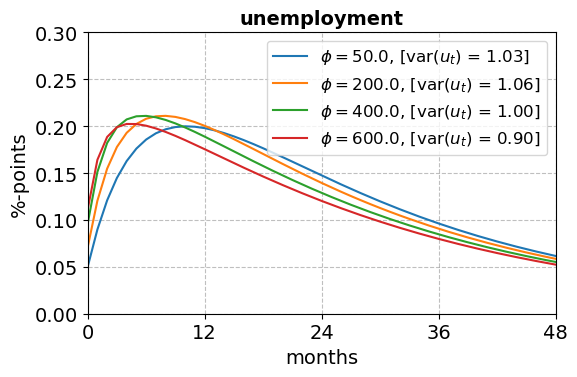

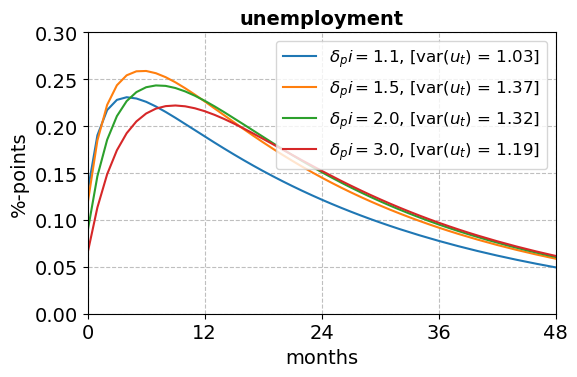

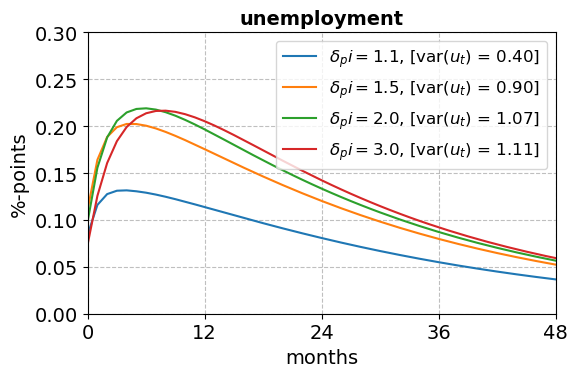

In [11]:
for parname in ['phi','delta_pi']:
    
    print(f'{parname}')
    
    for model_,name in [(model,'baseline'),(model_HtM_debt,'HtM_debt')]:
        
        print(f'{name}')
        
        values = values_dict[parname]
        models_ = vary_par(model_,parname,values,do_print=True,do_ss=False,skip_hh=True,show_info=True)
        labels = [f'${latex_dict[parname]} = {model_.par.__dict__[parname]:.1f}$, [var($u_t$) = {model_.moms["var_u"]:.2f}]' for model_ in models_]
        
        IRF_figs(models_,labels,None,colors,
                 title='unemployment',
                 prefix=f'robustness_{name}',
                 parname=parname,
                 varname='u',
                 legend=True,
                 ylim=[0.0,0.3,])
        
        print('')
        
    print('')
        

# Exogenous separations and free entry

In [12]:
SAM = model.copy()
SAM.par.phi = 0.001
SAM.find_ss()
SAM.compute_jacs(skip_hh=True,skip_shocks=True)
SAM.find_transition_path(do_end_check=False)

baseline


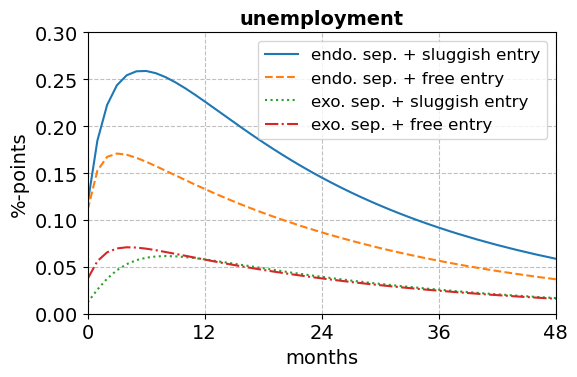

HtM_debt


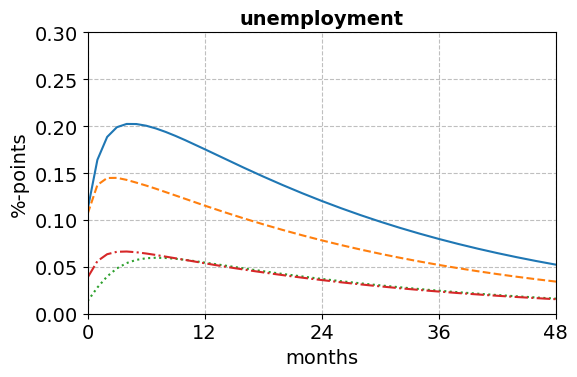

SAM


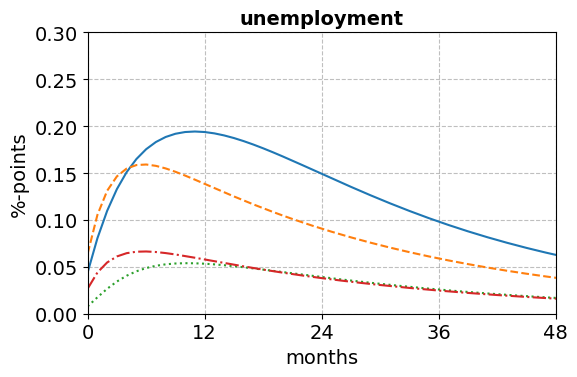

In [13]:
for model_,name in [(model,'baseline'),(model_HtM_debt,'HtM_debt'),(SAM,'SAM')]:
    
    print(name)
    
    model_endo_sep_free_entry = model_.copy()
    model_endo_sep_free_entry.par.xi = np.inf
    model_endo_sep_free_entry.set_macros(free_entry=True)

    model_exo_sep_free_entry = model_.copy()
    model_exo_sep_free_entry.par.psi = 0.0
    model_exo_sep_free_entry.par.exo_sep = True
    model_exo_sep_free_entry.par.xi = np.inf
    model_exo_sep_free_entry.set_macros(free_entry=True)
    
    model_exo_sep_sluggish_entry = model_.copy()
    model_exo_sep_sluggish_entry.par.psi = 0.0
    model_exo_sep_sluggish_entry.par.exo_sep = True
    
    for model__ in [model_endo_sep_free_entry,model_exo_sep_free_entry,model_exo_sep_sluggish_entry]:
        model__.find_ss()
        model__.compute_jacs(skip_shocks=True)
        model__.find_transition_path()        
    
    fig,ax = create_fig()

    ax.plot((model_.path.u[0,:]-model_.ss.u)*100,label='endo. sep. + sluggish entry')
    ax.plot((model_endo_sep_free_entry.path.u[0,:]-model_.ss.u)*100,label='endo. sep. + free entry',ls='--')
    ax.plot((model_exo_sep_sluggish_entry.path.u[0,:]-model_.ss.u)*100,label='exo. sep. + sluggish entry',ls=':')
    ax.plot((model_exo_sep_free_entry.path.u[0,:]-model_.ss.u)*100,label='exo. sep. + free entry',ls='-.')

    ax.set_ylim([0,0.3])
    save_fig(fig,ax,
             filename=f'interaction_endo_sep_sluggish_entry_{name}',
             title='unemployment',ylabel='%-points',legend=name=='baseline')
    
    plt.show()